In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
directory_path = '/content/drive/MyDrive/Frames_Store'
print(os.listdir(directory_path))

['Cropped.mp4', 'Frames']


In [ ]:
import cv2
import numpy as np
import torch
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.models as models
import torchvision.transforms as transforms
import os

In [ ]:
# Load the pre-trained Vision Transformer model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [ ]:
# Directory to save frames with significant changes
output_dir = "filtered_life_frames13"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
# Function to extract features from a frame using Vision Transformer
def extract_vit_features(frame):
    # Convert BGR (OpenCV format) to RGB and convert to float32 for ViT compatibility
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)

    # Convert frame to a list of one image to match the input format (batching required)
    inputs = feature_extractor(images=[frame_rgb], return_tensors="pt", padding=True)

    # Move input tensors to GPU if available
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Return the last hidden state (features from the ViT model) and move to CPU for further processing
    return outputs.last_hidden_state[0].cpu().numpy().flatten()

# Function to identify major changes between consecutive frames
def detect_major_changes(frames, change_threshold=50):
    frame_index = 0
    saved_frame_count = 0
    last_features = None

    # Loop through the list of frames
    for frame in frames:
        # Resize the frame to match the input size of ViT (224x224)
        frame_resized = cv2.resize(frame, (224, 224))

        # Extract ViT features from the current frame using the extract_vit_features function
        try:
            current_features = extract_vit_features(frame_resized)
        except Exception as e:
            print(f"Error extracting features from frame {frame_index}: {e}")
            continue

        if last_features is not None:
            # Compute the L2 distance between the current and the previous frame's features
            feature_diff = np.linalg.norm(current_features - last_features)

            # If the difference exceeds the threshold, save the frame
            if feature_diff > change_threshold:
                frame_filename = os.path.join(output_dir, f"changed_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved_frame_count += 1

                # Print the feature difference (removing extra debug info)
                print(f"Feature difference: {feature_diff:.2f}")

        # Update last_features for the next iteration
        last_features = current_features
        frame_index += 1

    # Print the total number of saved frames
    print(f"Total saved frames: {saved_frame_count}")

In [ ]:
import re
import os
import cv2

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "frame_" and "_cluster"
    match = re.search(r'frame_(\d+)_cluster', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

frames = []
frames_folder = "/content/drive/MyDrive/Frame-Detection/Data/processed-images/life-event-demo"  # Adjusted folder path

# Read all images (frames) from the folder and sort by frame number
for frame_file in sorted(os.listdir(frames_folder), key=get_frame_number):  # Sort by numeric part
    if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only reading image files
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)  # Read the frame
        if frame is not None:
            frames.append(frame)

# Debugging: Print the number of frames and check sorting
print(f"Total frames read: {len(frames)}")
print("First few frames:", sorted(os.listdir(frames_folder), key=get_frame_number)[:5])

# Call the function to detect major changes between the frames
detect_major_changes(frames, change_threshold=200)

Total frames read: 31
First few frames: ['extracted-frames', 'frame_00030_time_29.73.png', 'frame_00000_time_0.00.png', 'frame_00015_time_16.93.png', 'frame_00014_time_16.80.png']
Feature difference: 231.81
Feature difference: 248.76
Feature difference: 201.88
Feature difference: 204.77
Feature difference: 217.88
Feature difference: 243.50
Feature difference: 203.14
Feature difference: 208.04
Feature difference: 213.61
Feature difference: 229.97
Feature difference: 265.40
Feature difference: 266.73
Feature difference: 264.00
Feature difference: 250.47
Total saved frames: 14


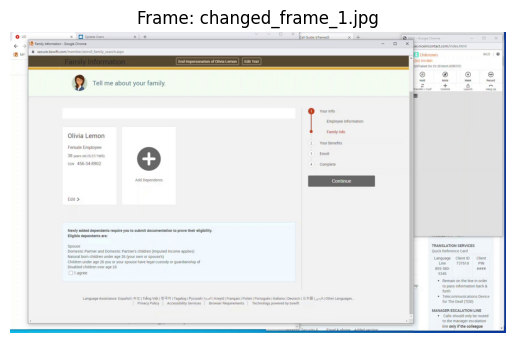

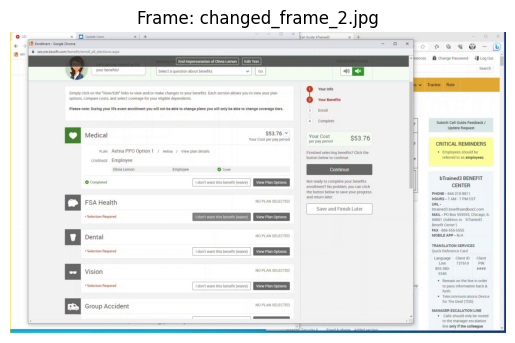

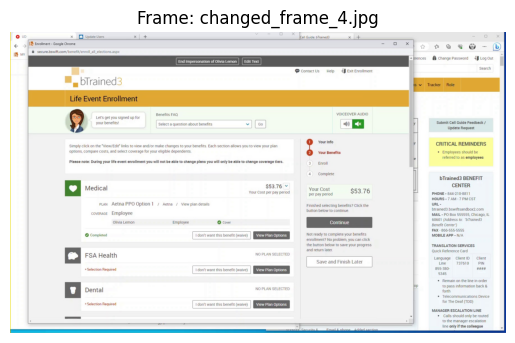

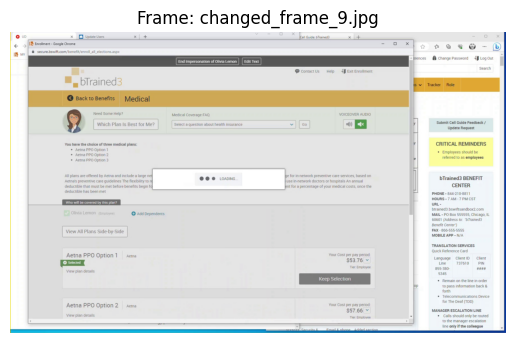

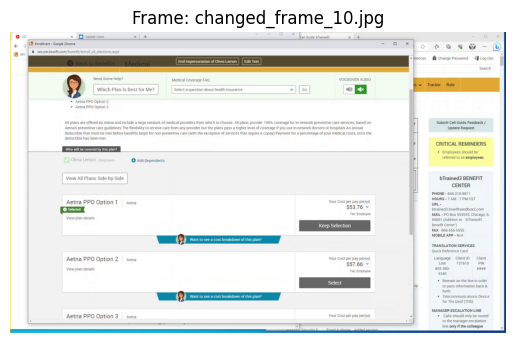

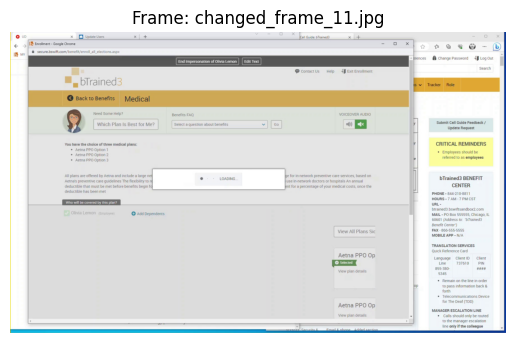

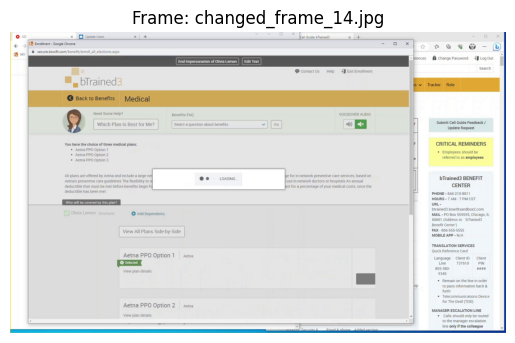

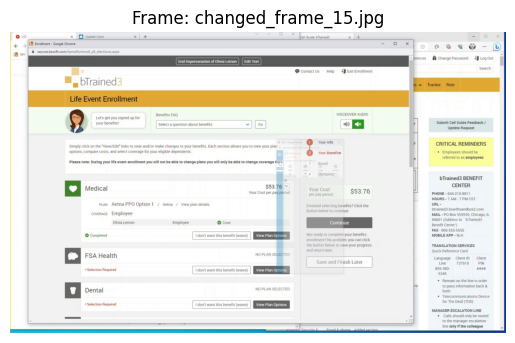

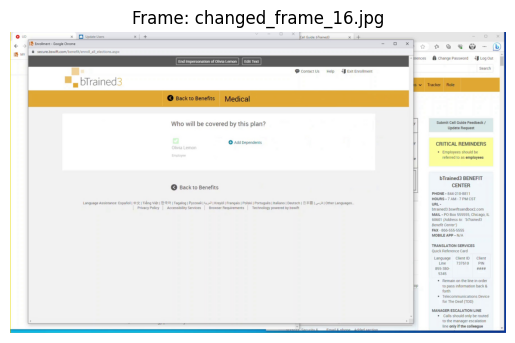

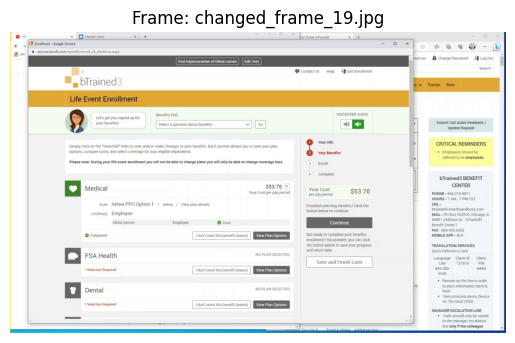

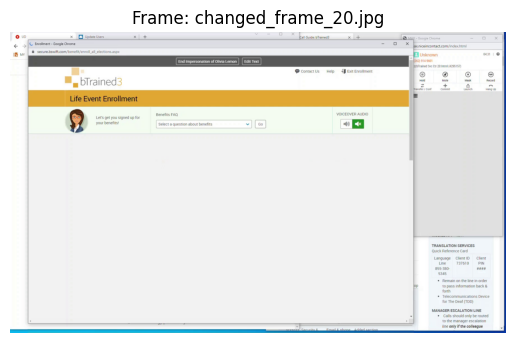

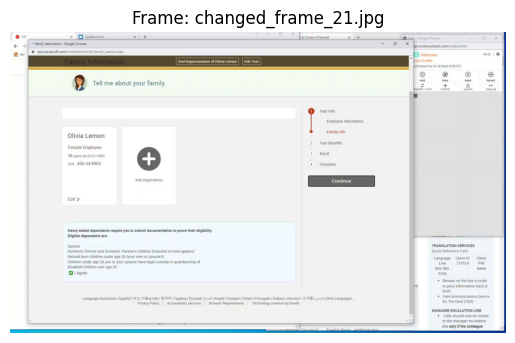

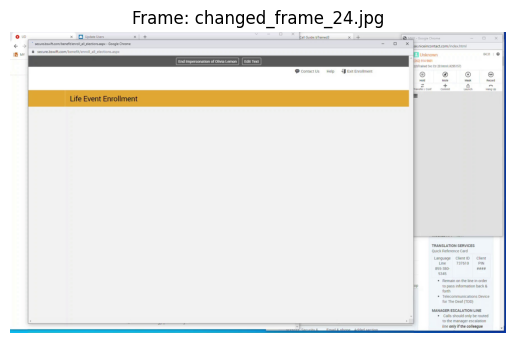

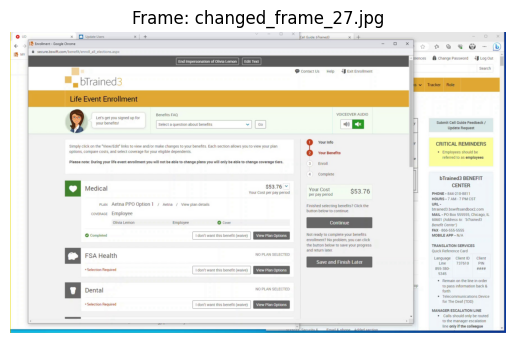

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory where the frames are saved
output_dir = "filtered_life_frames13"

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "changed_frame_" and ".jpg"
    match = re.search(r'changed_frame_(\d+)', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

# Check if the directory exists and contains files
if os.path.exists(output_dir):
    # List all the files in the directory and sort them by frame number
    saved_frames = sorted(os.listdir(output_dir), key=get_frame_number)

    # Loop through and display each saved frame
    for frame_file in saved_frames:
        if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only displaying image files
            frame_path = os.path.join(output_dir, frame_file)
            frame = cv2.imread(frame_path)

            # Convert BGR (OpenCV format) to RGB for displaying with matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            plt.imshow(frame_rgb)
            plt.title(f"Frame: {frame_file}")
            plt.axis('off')  # Turn off axis labels
            plt.show()
else:
    print(f"Directory {output_dir} does not exist or is empty.")


In [ ]:
import cv2
import numpy as np
import torch
from transformers import ViTFeatureExtractor, ViTModel
import os
import re

class VisionTransformerFrameAnalyzer:
    """
    A class to analyze frames using Vision Transformer (ViT) and detect major changes between them.
    This class extracts features from frames and compares consecutive frames to identify
    significant changes based on a threshold.
    """

    def __init__(self, model_name='google/vit-base-patch16-224', output_dir="filtered_vit_frames"):
        """
        Initialize the class with a Vision Transformer model and set up the output directory.

        Args:
            model_name (str): The name of the pre-trained Vision Transformer model.
            output_dir (str): The directory where frames with significant changes will be saved.
        """
        # Load the pre-trained Vision Transformer model and feature extractor
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
        self.model = ViTModel.from_pretrained(model_name)

        # Determine if a GPU is available and move the model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Directory to save frames with significant changes
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def extract_vit_features(self, frame):
        """
        Extract features from a frame using Vision Transformer.

        Args:
            frame (np.ndarray): A single frame (image) to extract features from.

        Returns:
            np.ndarray: Flattened feature vector of the frame.
        """
        # Convert BGR (OpenCV format) to RGB and cast to float32 for ViT compatibility
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Prepare the frame for the model by creating a batch of size 1
        inputs = self.feature_extractor(images=[frame_rgb], return_tensors="pt", padding=True)

        # Move input tensors to GPU if available
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Perform inference without computing gradients
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Return the last hidden state (features) from the model and move to CPU for further processing
        return outputs.last_hidden_state[0].cpu().numpy().flatten()

    def detect_major_changes(self, frames, change_threshold=50):
        """
        Detect major changes between consecutive frames by comparing their features.

        Args:
            frames (list): List of frames (images) to analyze.
            change_threshold (float): Threshold to determine a significant change between frames.
        """
        frame_index = 0
        saved_frame_count = 0
        last_features = None

        # Loop through each frame and analyze changes between consecutive frames
        for frame in frames:
            # Resize the frame to match the input size of ViT (224x224)
            frame_resized = cv2.resize(frame, (224, 224))

            # Extract ViT features from the current frame
            try:
                current_features = self.extract_vit_features(frame_resized)
            except Exception as e:
                print(f"Error extracting features from frame {frame_index}: {e}")
                continue

            # Compare the current frame's features with the last frame's features
            if last_features is not None:
                feature_diff = np.linalg.norm(current_features - last_features)

                # If the difference exceeds the threshold, save the frame
                if feature_diff > change_threshold:
                    frame_filename = os.path.join(self.output_dir, f"changed_frame_{frame_index}.jpg")
                    cv2.imwrite(frame_filename, frame)
                    saved_frame_count += 1
                    print(f"Feature difference: {feature_diff:.2f}")

            # Update the last_features to the current frame's features for the next iteration
            last_features = current_features
            frame_index += 1

        # Output the total number of saved frames
        print(f"Total saved frames: {saved_frame_count}")

    def get_frame_number(self, filename):
        """
        Extract the numeric part of the frame filename for sorting purposes.

        Args:
            filename (str): Filename of the frame.

        Returns:
            int: The extracted frame number, or -1 if not found.
        """
        match = re.search(r'frame_(\d+)_cluster', filename)
        if match:
            return int(match.group(1))
        else:
            return -1

    def read_frames_from_folder(self, frames_folder):
        """
        Read all frames from the given folder, sorted by their frame number.

        Args:
            frames_folder (str): Path to the folder containing the frames.

        Returns:
            list: List of frames (images) read from the folder.
        """
        frames = []

        # Read all image files from the folder, sorted by frame number
        for frame_file in sorted(os.listdir(frames_folder), key=self.get_frame_number):
            if frame_file.endswith((".png", ".jpg", ".jpeg")):
                frame_path = os.path.join(frames_folder, frame_file)
                frame = cv2.imread(frame_path)
                if frame is not None:
                    frames.append(frame)

        # Output debug info
        print(f"Total frames read: {len(frames)}")
        print("First few frames:", sorted(os.listdir(frames_folder), key=self.get_frame_number)[:5])
        return frames


In [ ]:
import cv2
import numpy as np
import torch
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import os
import re
from torch.utils.data import DataLoader, Dataset


In [ ]:
# Load the pre-trained Vision Transformer model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [ ]:
# Custom Dataset class for loading frames
class FramesDataset(Dataset):
    def __init__(self, frames_folder, transform=None):
        self.frames_folder = frames_folder
        self.frame_files = sorted(os.listdir(frames_folder), key=self.get_frame_number)
        self.transform = transform

    # Extract numeric part from filename for sorting
    def get_frame_number(self, filename):
        match = re.search(r'frame_(\d+)_cluster', filename)
        return int(match.group(1)) if match else -1

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_path = os.path.join(self.frames_folder, self.frame_files[idx])
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if self.transform:
            frame = self.transform(frame)

        return frame

# Define transformation for frames (resize to 224x224)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloader
dataset = FramesDataset("/content/drive/MyDrive/Frames_Store/Frames", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
# Define a contrastive loss for frame difference detection
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Compute the Euclidean distance between output1 and output2
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # Apply contrastive loss formula
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

# Add a classification head to the ViT model
class ViTForFrameDifference(nn.Module):
    def __init__(self):
        super(ViTForFrameDifference, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc = nn.Linear(self.vit.config.hidden_size, 128)  # Reduce to 128 dimensions

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x).last_hidden_state[:, 0, :]
        return self.fc(vit_outputs)  # Return features for frame difference


In [ ]:
# Instantiate the model
model = ViTForFrameDifference().to(device)

# Define the loss function and optimizer
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, frames in enumerate(dataloader):
        # Since it's contrastive learning, we take two consecutive frames for comparison
        frame1 = frames[:-1].to(device)
        frame2 = frames[1:].to(device)

        # Create pseudo-labels (1 for similar, 0 for different frames)
        labels = torch.zeros(frame1.size(0)).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output1 = model(frame1)
        output2 = model(frame2)

        # Calculate contrastive loss
        loss = criterion(output1, output2, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

print('Training complete!')

# Save the model for later use
torch.save(model.state_dict(), "vit_finetuned.pth")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Step [1/17], Loss: 1.9712
Epoch [1/10], Step [11/17], Loss: 0.1435
Epoch [1/10], Loss: 0.5372
Epoch [2/10], Step [1/17], Loss: 0.0776
Epoch [2/10], Step [11/17], Loss: 0.0699
Epoch [2/10], Loss: 0.0627
Epoch [3/10], Step [1/17], Loss: 0.0624
Epoch [3/10], Step [11/17], Loss: 0.0214
Epoch [3/10], Loss: 0.0354
Epoch [4/10], Step [1/17], Loss: 0.0386
Epoch [4/10], Step [11/17], Loss: 0.0260
Epoch [4/10], Loss: 0.0247
Epoch [5/10], Step [1/17], Loss: 0.0174
Epoch [5/10], Step [11/17], Loss: 0.0172
Epoch [5/10], Loss: 0.0181
Epoch [6/10], Step [1/17], Loss: 0.0102
Epoch [6/10], Step [11/17], Loss: 0.0180
Epoch [6/10], Loss: 0.0175
Epoch [7/10], Step [1/17], Loss: 0.0050
Epoch [7/10], Step [11/17], Loss: 0.0159
Epoch [7/10], Loss: 0.0143
Epoch [8/10], Step [1/17], Loss: 0.0190
Epoch [8/10], Step [11/17], Loss: 0.0074
Epoch [8/10], Loss: 0.0113
Epoch [9/10], Step [1/17], Loss: 0.0095
Epoch [9/10], Step [11/17], Loss: 0.0105
Epoch [9/10], Loss: 0.0114
Epoch [10/10], Step [1/17], 

In [ ]:
# Load the pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# Instantiate the model
model = ViTForFrameDifference()
# Load the fine-tuned weights
model.load_state_dict(torch.load("vit_finetuned.pth"))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()



Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-cc2577d5e6df>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

ViTForFrameDifference(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [ ]:
# Directory to save frames with significant changes
output_dir = "filtered_vit_frames11"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to extract features from a frame using the fine-tuned ViT model
def extract_vit_features_finetuned(frame):
    # Convert BGR (OpenCV format) to RGB and convert to float32 for ViT compatibility
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)

    # Convert frame to a list of one image to match the input format (batching required)
    inputs = feature_extractor(images=[frame_rgb], return_tensors="pt")

    # Move input tensors to GPU if available
    inputs = inputs["pixel_values"].to(device)  # Extract the pixel values only, since it's not expecting "pixel_values" arg

    # Perform inference using the fine-tuned model
    with torch.no_grad():
        outputs = model(inputs)  # Pass the tensor directly to the model, instead of using pixel_values

    # Return the features for frame difference detection (CLS token output)
    return outputs.cpu().numpy()

# Function to detect major changes between consecutive frames using fine-tuned model
def detect_major_changes_finetuned(frames, change_threshold=50):
    frame_index = 0
    saved_frame_count = 0
    last_features = None

    # Loop through the list of frames
    for frame in frames:
        # Resize the frame to match the input size of ViT (224x224)
        frame_resized = cv2.resize(frame, (224, 224))

        # Extract features from the current frame
        try:
            current_features = extract_vit_features_finetuned(frame_resized)
        except Exception as e:
            print(f"Error extracting features from frame {frame_index}: {e}")
            continue

        if last_features is not None:
            # Compute the L2 distance between the current and the previous frame's features
            feature_diff = np.linalg.norm(current_features - last_features)

            # If the difference exceeds the threshold, save the frame
            if feature_diff > change_threshold:
                frame_filename = os.path.join(output_dir, f"changed_frame_{frame_index}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved_frame_count += 1

                # Print the feature difference
                print(f"Feature difference: {feature_diff:.2f}")

        # Update last_features for the next iteration
        last_features = current_features
        frame_index += 1

    # Print the total number of saved frames
    print(f"Total saved frames: {saved_frame_count}")

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "frame_" and "_cluster"
    match = re.search(r'frame_(\d+)_cluster', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

frames = []
frames_folder = "/content/drive/MyDrive/Frames_Store/Frames"

# Read all images (frames) from the folder and sort by frame number
for frame_file in sorted(os.listdir(frames_folder), key=get_frame_number):  # Sort by numeric part
    if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only reading image files
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)  # Read the frame
        if frame is not None:
            frames.append(frame)

# Debugging: Print the number of frames and check sorting
print(f"Total frames read: {len(frames)}")
print("First few frames:", sorted(os.listdir(frames_folder), key=get_frame_number)[:5])

# Call the function to detect major changes between the frames
detect_major_changes_finetuned(frames, change_threshold=0.2)

Total frames read: 130
First few frames: ['frame_0_cluster_0.jpg', 'frame_1_cluster_1.jpg', 'frame_3_cluster_2.jpg', 'frame_4_cluster_3.jpg', 'frame_5_cluster_4.jpg']
Feature difference: 0.27
Feature difference: 0.28
Feature difference: 0.20
Feature difference: 0.29
Feature difference: 0.23
Feature difference: 0.22
Feature difference: 0.24
Feature difference: 0.23
Feature difference: 0.23
Feature difference: 0.22
Feature difference: 0.25
Feature difference: 0.32
Feature difference: 0.36
Feature difference: 0.21
Total saved frames: 14


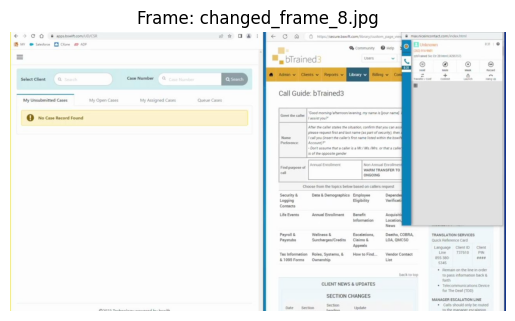

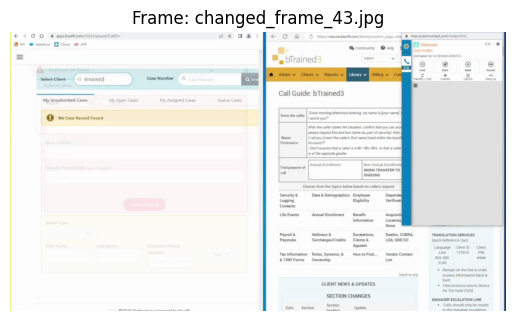

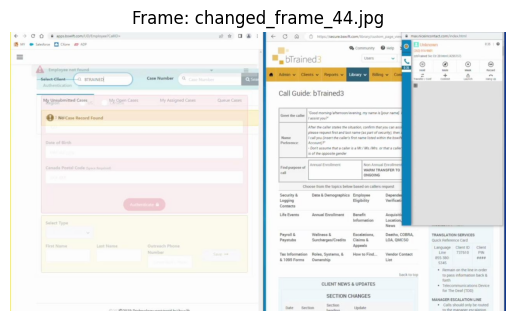

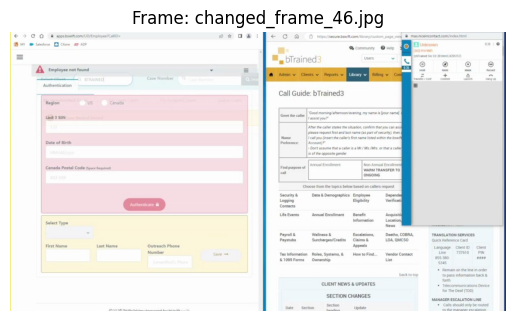

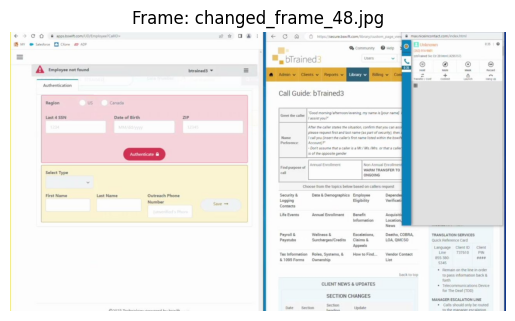

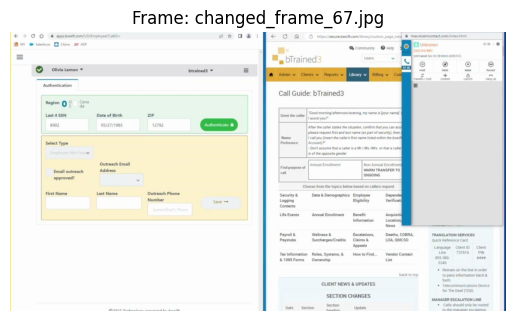

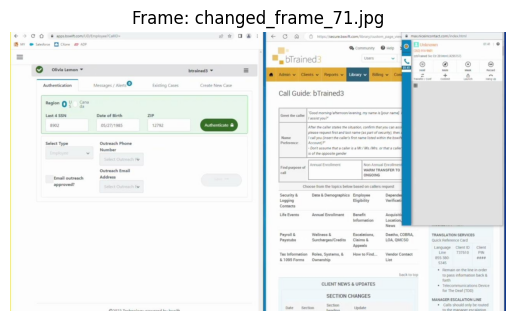

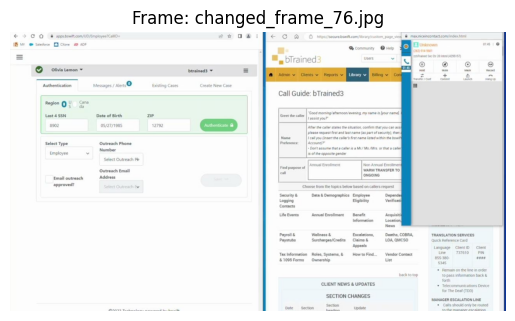

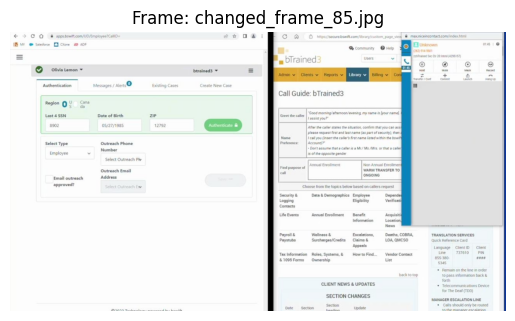

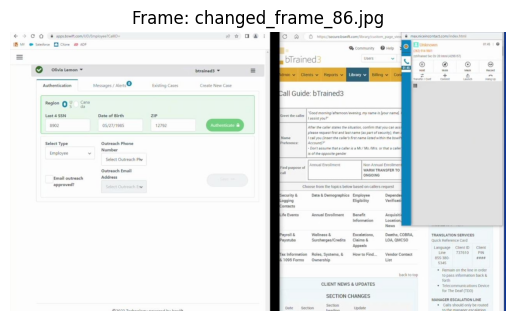

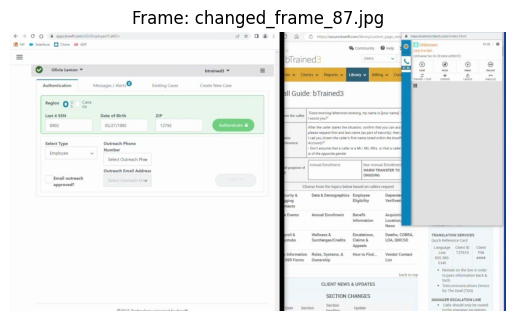

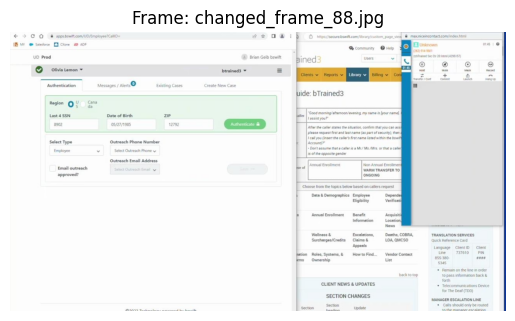

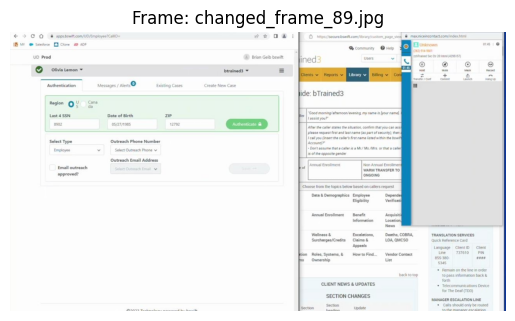

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory where the frames are saved
output_dir = "filtered_vit_frames11"

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "changed_frame_" and ".jpg"
    match = re.search(r'changed_frame_(\d+)', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

# Check if the directory exists and contains files
if os.path.exists(output_dir):
    # List all the files in the directory and sort them by frame number
    saved_frames = sorted(os.listdir(output_dir), key=get_frame_number)

    # Loop through and display each saved frame
    for frame_file in saved_frames:
        if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only displaying image files
            frame_path = os.path.join(output_dir, frame_file)
            frame = cv2.imread(frame_path)

            # Convert BGR (OpenCV format) to RGB for displaying with matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            plt.imshow(frame_rgb)
            plt.title(f"Frame: {frame_file}")
            plt.axis('off')  # Turn off axis labels
            plt.show()
else:
    print(f"Directory {output_dir} does not exist or is empty.")

In [ ]:
import os
directory_path = '/content/drive/MyDrive/Frame-Detection'
print(os.listdir(directory_path))

['Data', 'low_ssim_regions', 'Flow-detection_draft.ipynb', 'Blurry_detection_draft', 'SreenAI_zeroshot', 'Class_FrameExtractor.ipynb']


In [ ]:
# Directory to save frames with significant changes
output_dir = "filtered_life_frames1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "frame_" and "_cluster"
    match = re.search(r'frame_(\d+)_time', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

frames = []
frames_folder = "/content/drive/MyDrive/Frame-Detection/Data/processed-images/life-event-demo"

# Read all images (frames) from the folder and sort by frame number
for frame_file in sorted(os.listdir(frames_folder), key=get_frame_number):  # Sort by numeric part
    if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only reading image files
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)  # Read the frame
        if frame is not None:
            frames.append(frame)

# Debugging: Print the number of frames and check sorting
print(f"Total frames read: {len(frames)}")
print("First few frames:", sorted(os.listdir(frames_folder), key=get_frame_number)[:5])

# Call the function to detect major changes between the frames
detect_major_changes_finetuned(frames, change_threshold=0.2)

Total frames read: 31
First few frames: ['extracted-frames', 'frame_00000_time_0.00.png', 'frame_00001_time_3.60.png', 'frame_00002_time_5.33.png', 'frame_00003_time_5.73.png']
Feature difference: 0.98
Feature difference: 0.32
Feature difference: 0.51
Feature difference: 1.36
Feature difference: 0.40
Feature difference: 0.73
Feature difference: 0.69
Feature difference: 1.14
Feature difference: 0.34
Feature difference: 0.31
Feature difference: 0.29
Feature difference: 0.78
Feature difference: 0.33
Feature difference: 1.24
Total saved frames: 14


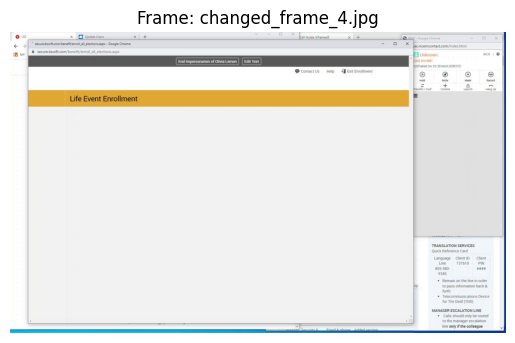

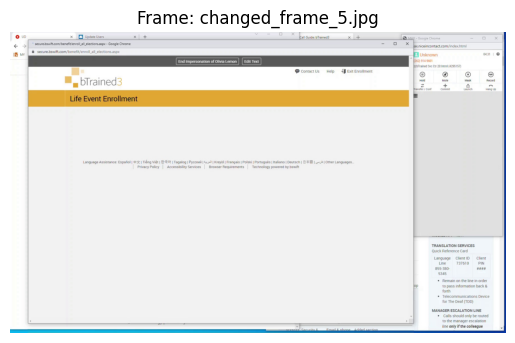

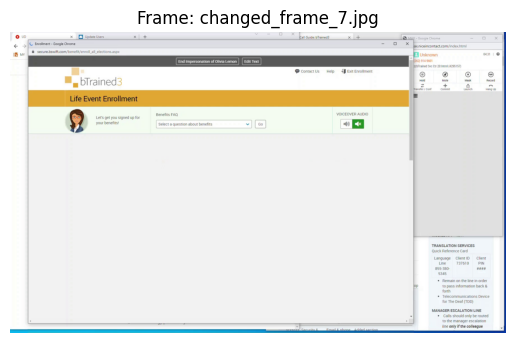

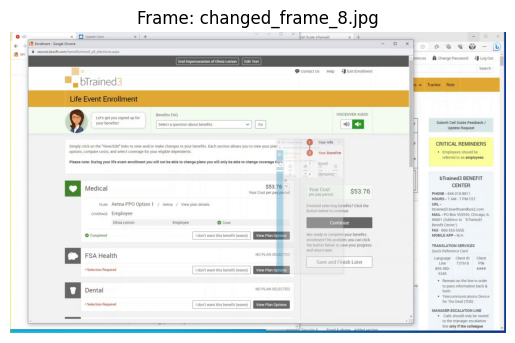

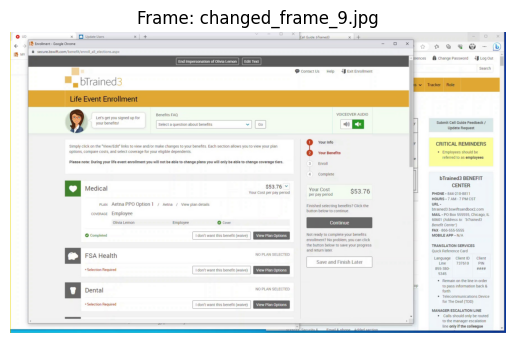

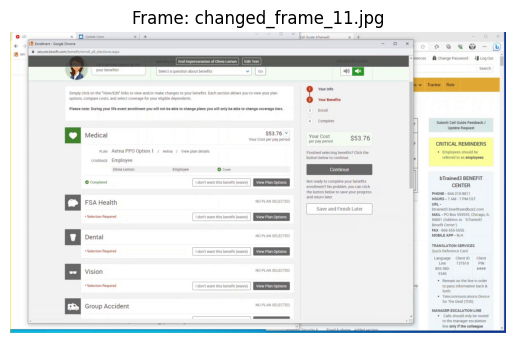

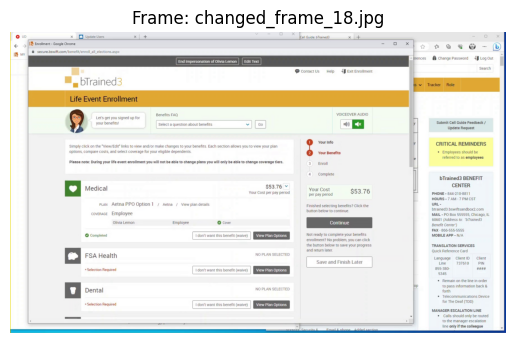

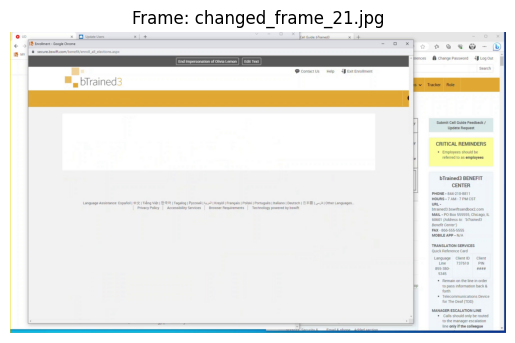

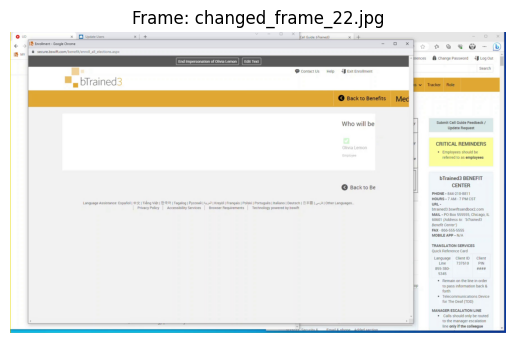

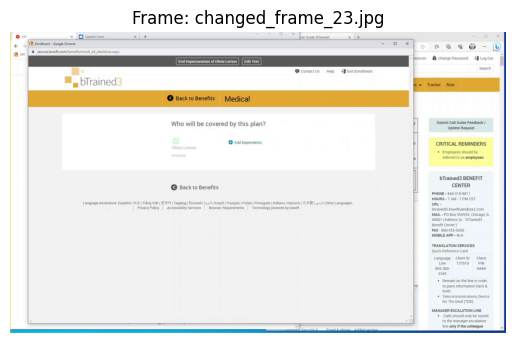

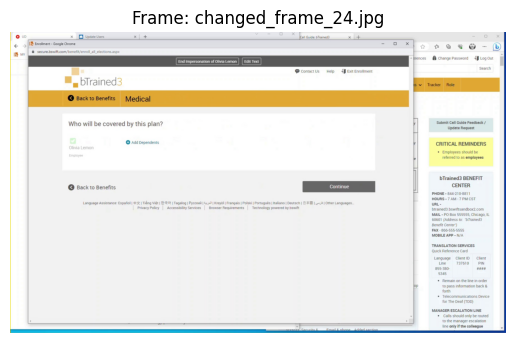

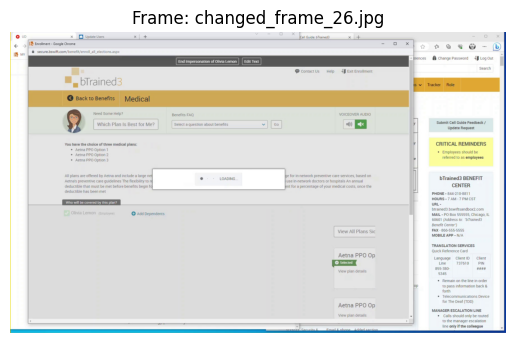

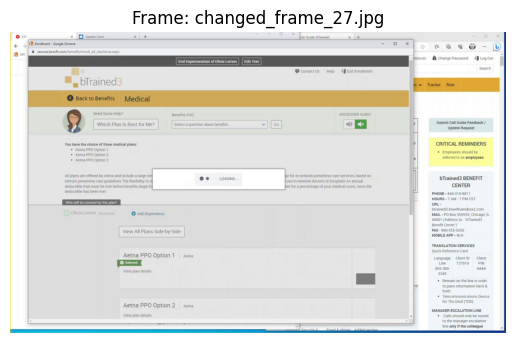

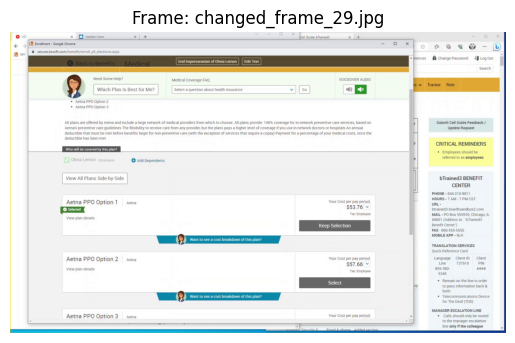

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory where the frames are saved
output_dir = "filtered_life_frames1"

# Custom function to extract the frame number from the filename
def get_frame_number(filename):
    # Extract numeric part between "changed_frame_" and ".jpg"
    match = re.search(r'changed_frame_(\d+)', filename)
    if match:
        return int(match.group(1))  # Return the frame number as an integer
    else:
        return -1  # In case there's no match, return -1

# Check if the directory exists and contains files
if os.path.exists(output_dir):
    # List all the files in the directory and sort them by frame number
    saved_frames = sorted(os.listdir(output_dir), key=get_frame_number)

    # Loop through and display each saved frame
    for frame_file in saved_frames:
        if frame_file.endswith((".png", ".jpg", ".jpeg")):  # Ensure you're only displaying image files
            frame_path = os.path.join(output_dir, frame_file)
            frame = cv2.imread(frame_path)

            # Convert BGR (OpenCV format) to RGB for displaying with matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame
            plt.imshow(frame_rgb)
            plt.title(f"Frame: {frame_file}")
            plt.axis('off')  # Turn off axis labels
            plt.show()
else:
    print(f"Directory {output_dir} does not exist or is empty.")